In [2]:
import tensorflow as tf
import keras
from keras import layers, models
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

2025-11-14 12:41:15.431505: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 12:41:15.441526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763116875.454067   42410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763116875.457735   42410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763116875.467416   42410 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# STEP 1: Load and Explore the CIFAR-10 Dataset

In [3]:
train_set, test_set = cifar10.load_data()

X_train, y_train = train_set
X_test, y_test = test_set

# CIFAR-10 contains 60,000 32x32 color images in 10 classes
# 50,000 training images and 10,000 test images
print(f"Training data shape: {X_train.shape}")  # (50000, 32, 32, 3)
print(f"Training labels shape: {y_train.shape}")  # (50000, 1)
print(f"Test data shape: {X_test.shape}")  # (10000, 32, 32, 3)
print(f"Test labels shape: {y_test.shape}")  # (10000, 1)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [4]:
print(y_train[0:5])

[[6]
 [9]
 [9]
 [4]
 [1]]


# STEP 2: Data Preprocessing


In [5]:
# Normalize Pixel values to be between [0,1]

X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0


In [6]:
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

print(f"  Converted labels to one-hot encoding")
print(f"  Original label shape: {y_train.shape}")
print(f"  One-hot label shape: {y_train_categorical.shape}")

  Converted labels to one-hot encoding
  Original label shape: (50000, 1)
  One-hot label shape: (50000, 10)


In [7]:
validation_split = 0.1
val_size = int(len(X_train)*validation_split)

X_val = X_train[:val_size]
y_val = y_train_categorical[:val_size]

X_train_final = X_train[val_size:]
y_train_final = y_train_categorical[val_size:]

print(f"  Created validation set")
print(f"  Training samples: {len(X_train_final)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Test samples: {len(X_test)}")

  Created validation set
  Training samples: 45000
  Validation samples: 5000
  Test samples: 10000


# STEP 3: Build Custom CNN Architecture


In [8]:
def build_cnn_model(input_shape = (32,32,3), num_classes = 10):

    model = models.Sequential(name="AGNet_CIFAR10_CNN")

    # Block 1
    model.add(layers.Conv2D(32,(3,3), activation='relu', padding='same',input_shape=input_shape,name='conv1_1'))
    model.add(layers.BatchNormalization(name='bn1_1'))

    model.add(layers.Conv2D(32,(3,3), activation='relu', padding='same',name='conv1_2'))
    model.add(layers.BatchNormalization(name='bn1_2'))

    model.add(layers.MaxPooling2D((2,2), name='pool1'))
    
    model.add(layers.Dropout(0.25, name='dropout1'))

    
    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'))
    model.add(layers.BatchNormalization(name='bn2_1'))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'))
    model.add(layers.BatchNormalization(name='bn2_2'))
    
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.25, name='dropout2'))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'))
    model.add(layers.BatchNormalization(name='bn3_1'))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2'))
    model.add(layers.BatchNormalization(name='bn3_2'))
    
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    model.add(layers.Dropout(0.25, name='dropout3'))


    # ========== DENSE LAYERS ==========
    # Flatten the 3D output to 1D for dense layers
    model.add(layers.Flatten(name='flatten'))

    # Fully connected layer for learning complex combinations

    # FC layer 1
    model.add(layers.Dense(256, activation='relu', name='dense1'))
    model.add(layers.BatchNormalization(name='bn_dense1'))
    model.add(layers.Dropout(0.5, name='dropout_dense1'))

    # FC layer 2
    model.add(layers.Dense(128, activation='relu', name='dense2'))
    model.add(layers.BatchNormalization(name='bn_dense2'))
    model.add(layers.Dropout(0.5, name='dropout_dense2'))

    # Output layer with softmax for probability distribution over classes
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))
    
    return model


In [9]:
model = build_cnn_model()
model.summary()


/home/gomaa/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-14 12:41:19.252804: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-11-14 12:41:19.252830: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-14 12:41:19.252834: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: gomaa-LOQ-15IAX9
2025-11-14 12:41:19.252836: I exter

Model: "AGNet_CIFAR10_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 8, 8, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 8, 8, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense1 (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense2 (BatchNormalization)  │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense2 (Dropout)        │ (None, 128)            │             

 Total params: 849,066 (3.24 MB)

 Trainable params: 847,402 (3.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

# STEP 4: Compile the Model

In [10]:
model.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

print("  Model compiled successfully")
print(f"  Optimizer: {model.optimizer.name}")
print(f"  Loss function: {model.loss}")
print(f"  Metrics: Accuracy + \n{model.metrics}")

  Model compiled successfully
  Optimizer: adam
  Loss function: categorical_crossentropy
  Metrics: Accuracy + 
[<Mean name=loss>, <CompileMetrics name=compile_metrics>]


# STEP 5: Set Up Callbacks

### Callback 1: Reduce learning rate when validation loss plateaus
 

In [11]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor= 'val_loss',
    factor= 0.5, # reduce lr by half
    patience= 3, # wait 3 epochs at least before reducing
    min_lr= 1e-7,
    verbose=1
)

### Callback 2: Early stopping to prevent overfitting
 

In [12]:
early_stopper = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # stop if no improvment for 10 epochs
    restore_best_weights=True,
    verbose=1
)

### Callback 3: Save best model


In [13]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_cifar10_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [14]:
callbacks = [reduce_lr, early_stopper, model_checkpoint]

# STEP 7: Train the Model

In [15]:
# Training parameters
EPOCHS = 50
BATCH_SIZE = 64

In [16]:
print(tf.config.list_physical_devices('GPU'))
print(tf.sysconfig.get_build_info()['cudnn_version'])
print(tf.sysconfig.get_build_info()['cuda_version'])

[]
9
12.5.1


In [17]:
print(f"Starting training for {EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}")
print(f"This may take several minutes...\n")

# Train the model
history = model.fit(X_train_final,y_train_final,
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_val,y_val),
                    callbacks=callbacks,
                    verbose=1)

print("\n Training completed!")

Starting training for 50 epochs...
Batch size: 64
This may take several minutes...

Epoch 1/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2948 - loss: 2.2412
Epoch 1: val_accuracy improved from -inf to 0.54100, saving model to best_cifar10_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.2950 - loss: 2.2400 - val_accuracy: 0.5410 - val_loss: 1.2627 - learning_rate: 0.0010
Epoch 2/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5450 - loss: 1.2774
Epoch 2: val_accuracy improved from 0.54100 to 0.55880, saving model to best_cifar10_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.5451 - loss: 1.2772 - val_accuracy: 0.5588 - val_loss: 1.2802 - learning_rate: 0.0010
Epoch 3/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6434 - loss: 1.0085
Epoch 3: val_accuracy improved from 0.55880 to 0.71320, saving model to best_cifar10_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.6434 - loss: 1.0084 - va

# STEP 8: Evaluate the Model


In [18]:
test_loss, test_accuracy = model.evaluate(X_test,y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Test Loss: 0.4744
Test Accuracy: 0.8678 (86.78%)


# STEP 9: Visualize Training History

✓ Training history plot saved as 'training_history.png'


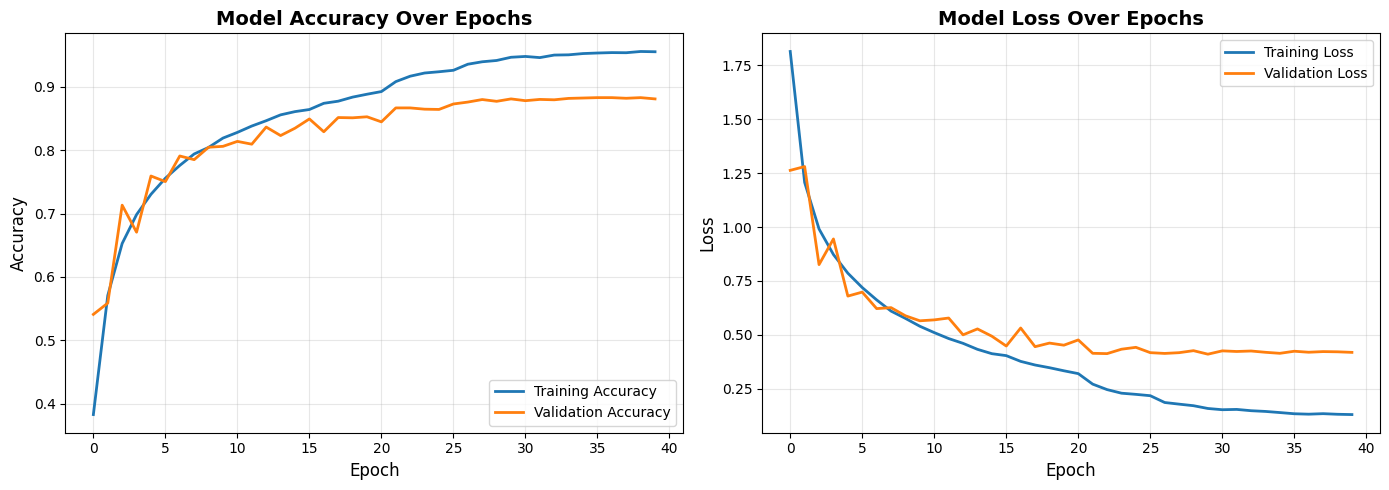

In [19]:

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Training history plot saved as 'training_history.png'")
plt.show()



# STEP 10: Make Predictions and Visualize Results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
✓ Predictions visualization saved as 'predictions_visualization.png'


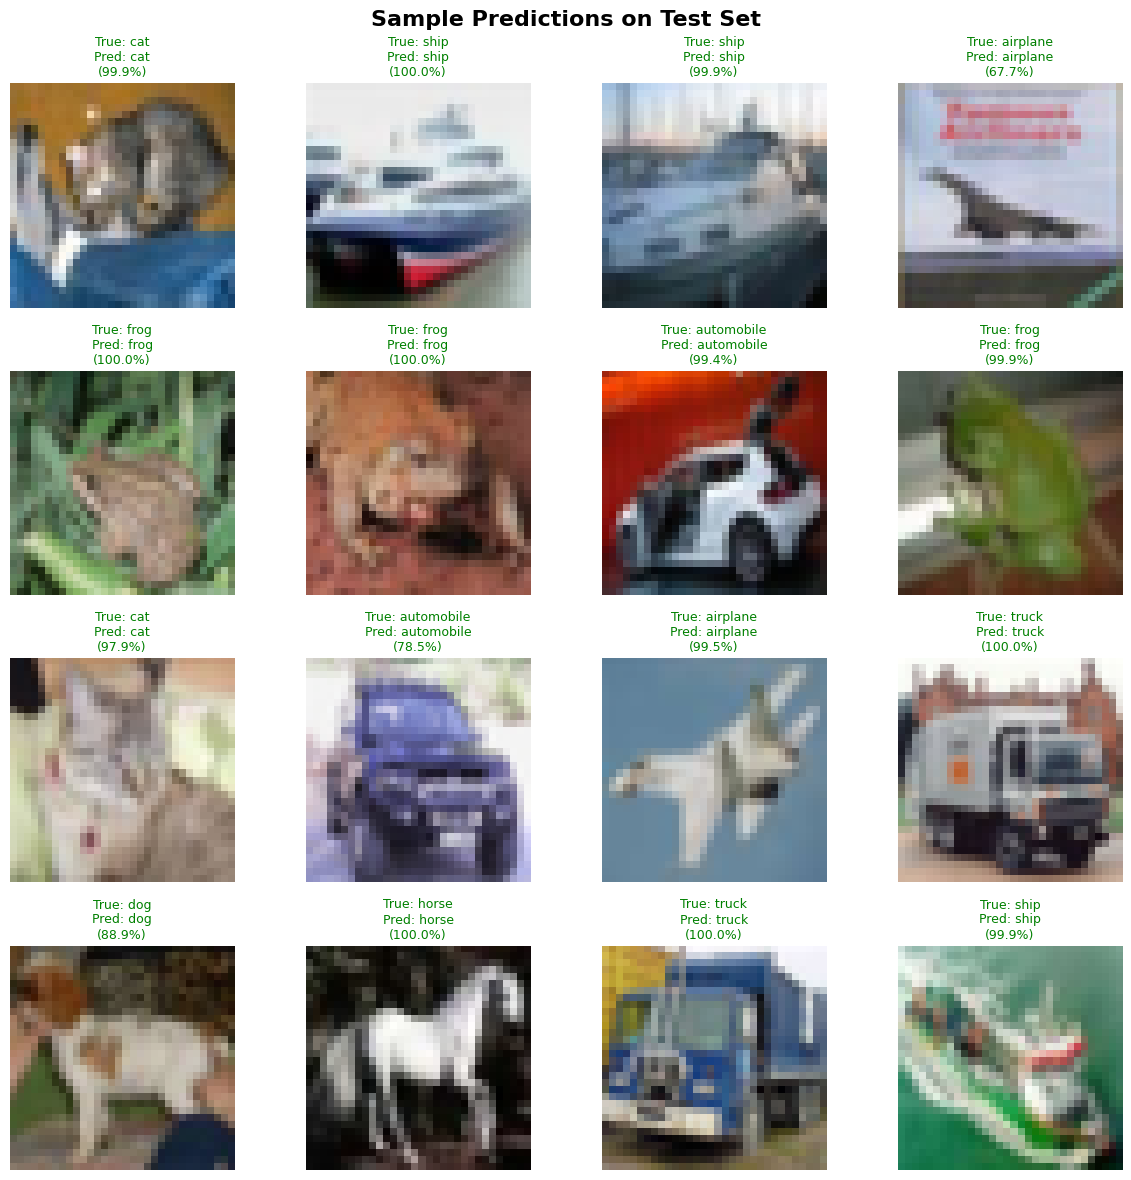

In [20]:

# Make predictions on test set
predictions = model.predict(X_test[:16])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test[:16].flatten()

# Visualize predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow(X_test[i])
    
    # Prepare label
    true_label = class_names[true_classes[i]]
    pred_label = class_names[predicted_classes[i]]
    confidence = predictions[i][predicted_classes[i]] * 100
    
    # Color code: green if correct, red if wrong
    color = 'green' if true_classes[i] == predicted_classes[i] else 'red'
    
    ax.set_title(f'True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)',
                fontsize=9, color=color)
    ax.axis('off')

plt.tight_layout()
plt.savefig('predictions_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Predictions visualization saved as 'predictions_visualization.png'")
plt.show()

# SUMMARY


In [21]:
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
print(f"Model saved as: 'best_cifar10_model.keras'")
print("=" * 60)
print(" All steps completed successfully!")
print("=" * 60)


TRAINING SUMMARY
Final Training Accuracy: 0.9552
Final Validation Accuracy: 0.8808
Final Test Accuracy: 0.8678
Total Epochs Trained: 40
Model saved as: 'best_cifar10_model.keras'
 All steps completed successfully!
